In [1]:
//#pragma include_alias("/local/vtk-m/clang/include/vtkm-1.2/vtkm/thirdparty/taotuple/vtkmtaotuple/","vtkmtaotuple")
#include <lodepng_config_cling.h>
#pragma cling add_include_path("/home/mark/local/vtkm-master/include/vtkm-1.3/")
#pragma cling add_library_path("/home/mark/local/vtkm-master/lib/")
#pragma cling load("vtkm_cont-1.3")
#pragma cling load("vtkm_rendering-1.3")

In [2]:
#include <vtkm/cont/DeviceAdapter.h>
#include <vtkm/cont/testing/MakeTestDataSet.h>
#include <vtkm/cont/testing/Testing.h>
#include <vtkm/rendering/Actor.h>
#include <vtkm/rendering/Mapper.h>
#include <vtkm/rendering/Scene.h>
#include <vtkm/rendering/View3D.h>
#include <vtkm/cont/ColorTable.h>
#include <vtkm/rendering/testing/RenderTest.h>
#include <vtkm/io/reader/VTKDataSetReader.h>
#include <vtkm/cont/internal/IteratorFromArrayPortal.h>
#include <vtkm/cont/ArrayPortalToIterators.h>
#include <vtkm/cont/DynamicArrayHandle.h>
#include <vtkm/cont/ArrayCopy.h>

#include "Reader.h"
#include "UFLIC.h"
#include "CanvasUFLIC.h"
#include "ViewUFLIC.h"
#include "MapperUFLIC.h"

In [3]:
template <typename VecType, vtkm::Id Size>
class ReaderScreenSpace : public Reader<VecType, Size>
{
public:
  using ColorBufferType = vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 4>>;
  using EvalType = VectorField<VecType>;

  using ArrayType = vtkm::cont::ArrayHandle<vtkm::Vec<VecType, Size>>;
  
  ReaderScreenSpace(vtkm::rendering::Canvas& _canvas)
    : Reader<VecType, Size>("",
                            vtkm::Id2(_canvas.GetWidth(),_canvas.GetHeight()),
                            Bounds(0, _canvas.GetWidth(), 0, _canvas.GetWidth()),
                            vtkm::Vec<VecType, Size>(1,1),
                            1
                            )
    ,canvas(_canvas)
  {
      std::cout << this->dim << std::endl;
  }
  void readFile()
  {
  
    this->ah.Allocate(canvas.GetColorBuffer().GetNumberOfValues());
    std::cout << this->ah.GetNumberOfValues() << std::endl;
    parse(this->ah);

  }

  void next(ArrayType  &in)
  {
    in = this->ah;
  }

  void parse(ArrayType in)
  {
    ColorBufferType::PortalConstControl colorPortal = canvas.GetColorBuffer().GetPortalConstControl();
    std::cout << this->dim << std::endl;  
    for (int y=0; y<this->dim[1]; y++){
        for (int x=0; x<this->dim[0]; x++){
            int idx = y*this->dim[0] + x;
              auto vec  = colorPortal.Get(idx);
              in.GetPortalControl().Set(idx, vtkm::Vec<vtkm::Float32, 2>(vec[0],vec[1]));        
        }
        
    }
    }
    vtkm::rendering::Canvas canvas;
    ArrayType ah;
};


In [4]:
 
vtkm::cont::ArrayHandle<int> runUFLIC(vtkm::rendering::Canvas &canvas)
{
    const int Size = 2;
    using VecType = vtkm::Float32;
    using ReaderType = ReaderScreenSpace<VecType, Size>;

    auto reader = std::shared_ptr<ReaderType>(new ReaderType(canvas));
    UFLIC<VectorField<VecType,Size>,VecType,Size> uflic;
    uflic.do_print = true;
    uflic.run(reader);
    return uflic.result;

};


Use lodepng to save out png instead of pnm so jupyter can read it.


In [5]:
#include <lodepng.h>
template<typename CanvasType>
void convertPng(CanvasType &canvas, std::vector<std::uint8_t> &ImageBuffer)
{
    int width = canvas.GetWidth();
    int height = canvas.GetHeight();
  std::vector<std::uint8_t> PngBuffer(width*height*4);

  using ColorBufferType = vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32, 4>>;

  ColorBufferType::PortalConstControl colorPortal = canvas.GetColorBuffer().GetPortalConstControl();

  for (vtkm::Id yIndex = 0; yIndex < height; yIndex++)
  {
    for (vtkm::Id xIndex = 0; xIndex < width; xIndex++)
    {
      vtkm::Vec<vtkm::Float32, 4> tuple = colorPortal.Get(yIndex * width + xIndex);
      //of << (unsigned char)(tuple[0] * 255);
      //of << (unsigned char)(tuple[1] * 255);
      //of << (unsigned char)(tuple[2] * 255);
        
        std::size_t NewPos = (height - yIndex - 1) * (width * 4) + 4 * xIndex;
        PngBuffer[NewPos + 0] = (unsigned char)(tuple[0] * 255);
        PngBuffer[NewPos + 1] = (unsigned char)(tuple[1] * 255);
        PngBuffer[NewPos + 2] = (unsigned char)(tuple[2] * 255);
        PngBuffer[NewPos + 3] = 255; 

    }
  }
  lodepng::encode(ImageBuffer, PngBuffer, width, height);
//lodepng::save_file(ImageBuffer, fn.c_str());    
}



In [6]:
#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

namespace im
{
    struct image
    {
        inline image(){}
        inline image(const std::vector<uint8_t> &png)
        {
            m_buffer.assign(png.begin(), png.end());
        }

        std::string m_buffer;
    };

    nlohmann::json mime_bundle_repr(const image& i)
    {
        auto bundle = nlohmann::json::object();
        bundle["image/png"] = xtl::base64encode(i.m_buffer);
        return bundle;
    }
}

std::unique_ptr<im::image> displayImage = std::unique_ptr<im::image>();


The default vtkm::rendering::View3D render both world space annotations (think bounding measuring box) and screen space annotations (think color bar). For screen space line integral convolution, we need to remove those.

In [7]:
inline void SetCamera(vtkm::rendering::Camera& camera,
                      const vtkm::Bounds& coordBounds)
{
  camera = vtkm::rendering::Camera();
  camera.ResetToBounds(coordBounds);
  camera.Azimuth(static_cast<vtkm::Float32>(45.0));
  camera.Elevation(static_cast<vtkm::Float32>(45.0));
};



In [8]:
void Render(ViewUFLIC& view)
{
  view.Initialize();
  view.Paint();
};


In [9]:
inline vtkm::cont::DataSet readVTKDataSet(const char* fname)
{
  vtkm::cont::DataSet ds;
  vtkm::io::reader::VTKDataSetReader reader(fname);
  try
  {
    ds = reader.ReadDataSet();
  }
  catch (vtkm::io::ErrorIO& e)
  {
    std::string message("Error reading: ");
    message += fname;
    message += ", ";
    message += e.GetMessage();

    VTKM_TEST_FAIL(message.c_str());
  }

  return ds;
}

In [10]:
void addField(vtkm::cont::DataSet &ds){
    auto cnt = ds.GetField(0).GetData().GetNumberOfValues();
    vtkm::cont::DataSetFieldAdd dsf;
    std::vector<vtkm::Float32> vars(cnt);
    for (int i=0; i<cnt ;i++){
        vars[i] = i/vtkm::Float32(cnt);
    }
        
    
    dsf.AddPointField(ds, "pointvar", vars);

};

In [11]:
vtkm::cont::ColorTable buildColorTableFromArray(const vtkm::cont::DynamicArrayHandle &_h){
    
    auto handle = _h.Cast<vtkm::cont::ArrayHandle<vtkm::Vec<vtkm::Float32,3>>>();
    std::vector<double> out(_h.GetNumberOfValues()*4);
    for (int i=0; i<handle.GetNumberOfValues(); i++){
        auto tmp = handle.GetPortalConstControl().Get(i);
        out[i*4] = tmp[0];
        out[i*4+1] = tmp[1];
        out[i*4+2] = tmp[2];
        out[i*4+3] = 0.0;
        if (i == 0)
            std::cout << handle.GetPortalConstControl().Get(i) << std::endl;
    }

    std::string name = "inplace";
    vtkm::Vec<double,3> nanIs(0,0,0);
     return vtkm::cont::ColorTable(name, vtkm::cont::ColorSpace::LAB, nanIs, 
                              out);
    
};

CanvasUFLIC
[113.504,29.2415,-40.6343]
{ X:[0.0987893..1.63144], Y:[0.027149..0.34988], Z:[0.0131184..0.379522] }
writetocanvas 1
My write to canvas!


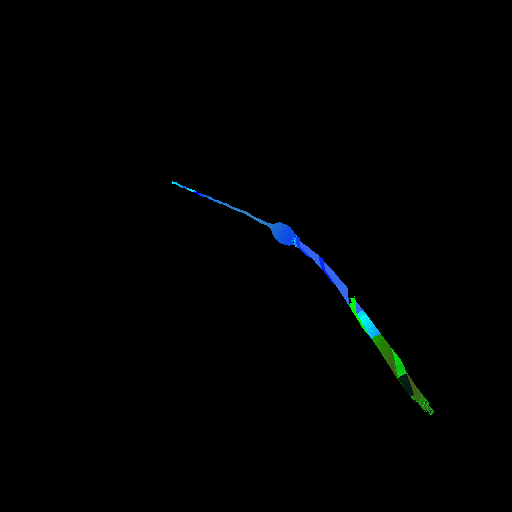

[512,512]
262144
[512,512]
Finished dt: 0.1 cnt: 1 time: 28.3224 s


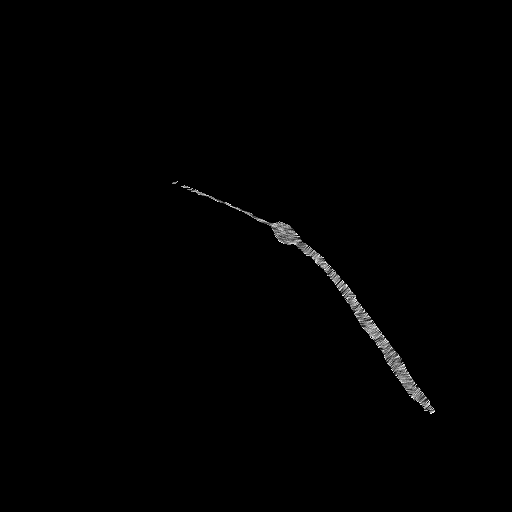

In [12]:
#include <xcpp/xdisplay.hpp>

[=](){
    auto try_and_err = [](){
                using M = MapperUFLIC;
using C = CanvasUFLIC;
using V3 = ViewUFLIC;
using V2 = vtkm::rendering::View2D;

        M mapper;
        mapper.SetShadingOn(false);
const vtkm::Id2 dim(512,512);
C canvas(dim[0],dim[1]);
vtkm::rendering::Scene scene;
auto ds = readVTKDataSet("edelta-velocity.vtk");
 addField(ds);
 vtkm::cont::ColorTable colorTable = buildColorTableFromArray(ds.GetField(0).GetData());
 static std::string fieldNm = "pointvar";

scene.AddActor(vtkm::rendering::Actor(
ds.GetCellSet(), ds.GetCoordinateSystem(), ds.GetField(fieldNm), colorTable));
vtkm::rendering::Camera camera;
SetCamera(camera, ds.GetCoordinateSystem().GetBounds());
    std::cout << ds.GetCoordinateSystem().GetBounds() << std::endl;
vtkm::rendering::Color background(0.0f, 0.0f, 0.0f, 1.0f);
vtkm::rendering::Color foreground(1.0f, 0.0f, 0.0f, 1.0f);
V3 view(scene, mapper, canvas, camera, background, foreground);

    Render(view);
  std::vector<std::uint8_t> png;
  convertPng(canvas, png);
   
     displayImage = std::make_unique<im::image>(png);
         xcpp::display(*displayImage);
        auto outArray = runUFLIC(canvas);
        vtkm::rendering::Canvas canvasUFLIC(dim[0], dim[1]);
        vtkm::cont::ArrayCopy(outArray, canvasUFLIC.GetColorBuffer());
        std::vector<std::uint8_t> png_uflic;
        convertPng(canvasUFLIC, png_uflic);
        displayImage = std::make_unique<im::image>(png_uflic);
        xcpp::display(*displayImage);
    };
    try_and_err();
}()